In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
import warnings
import scipy.stats as stats
# Ignore warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder as ore

In [14]:
df = pd.read_csv("cleaned_df.csv")

In [15]:

X = df.drop(columns=["G3"])
y = df['G3']


# Model Building

## First we will define our features and our target

In [16]:
def denormalize(y):#this is a denormalize function
    u=np.mean(df['G3'])
    sigma=np.std(df['G3'])
    for i in y:
        i=i*sigma+u
    return y

In [17]:
def significance_hypothesis_test(X,y_train,y_pred,coeff):
    N=len(y_train)
    numerator=np.sqrt(mean_squared_error(y_train,y_pred)*(N/(N-2)))
    SE=[]
   
    cols=X.columns.copy()
    for column in cols:
        denomenator=np.sqrt(np.std(X[column])*N)
        SE.append(numerator/denomenator)
    Z_score=[]
    p_score=[]
    new_coeff=[]
  

    

    for i in range(len(coeff)):
        Z_score.append(coeff[i]/SE[i])
        p_score.append(2*stats.norm.cdf(-abs(Z_score[i])))
        if(p_score[i]<0.05):
            new_coeff.append((coeff[i],X.columns[i]))
        else:
            new_coeff.append((0,X.columns[i]))
    return new_coeff,p_score,Z_score
    
    

In [18]:
df = pd.read_csv("cleaned_df.csv")

In [19]:
pipe=Pipeline([('ore',ore()),('Normalizer',Normalizer()),('Ridge',Ridge())])


In [20]:
pipe.fit(X,y)
y_pred_norm=pipe.predict(X)
y_pred=denormalize(y_pred_norm)
mse = mean_squared_error(y, y_pred)
print("MSE Score: ",mse)
rs=r2_score(y,y_pred)
print("R^2 Score: ",rs)
enc=ore()

X1=enc.fit_transform(X)

encoded_df = pd.DataFrame(X1,columns=enc.get_feature_names_out(X.columns))

nc,ps,zs=significance_hypothesis_test(encoded_df,y,y_pred,pipe.named_steps['Ridge'].coef_)
print(sorted(nc))
print(ps)
print(zs)


MSE Score:  1.9372166794863541
R^2 Score:  0.7158669150317205
[(-4.251631314929466, 'Fjob'), (-4.249551346879617, 'Pstatus'), (-4.246244464433091, 'health'), (-2.8268549964940455, 'school'), (-2.7967552989424074, 'freetime'), (-2.350315197494153, 'higher'), (-2.3170995447527134, 'famsup'), (-2.236944092235071, 'goout'), (-2.13391335691757, 'guardian'), (-1.978334184201354, 'famrel'), (-1.9667702825175144, 'schoolsup'), (-1.920520019916024, 'romantic'), (-1.9031221880883962, 'famsize'), (-1.8065716042626934, 'nursery'), (-1.7465399653503224, 'address'), (-1.5867554360451794, 'traveltime'), (-1.5483695454272655, 'Fedu'), (-1.2303925922255403, 'sex'), (-1.2237898803373994, 'failures'), (-1.2094972492308005, 'Walc'), (-1.2010520210302502, 'activities'), (-1.031172629368273, 'absences'), (-0.9807171373741369, 'internet'), (-0.9374703724502994, 'reason'), (-0.805689615824041, 'Dalc'), (-0.63483440414164, 'paid'), (-0.39803660486462106, 'studytime'), (0, 'Medu'), (0, 'age'), (0.55410871500276

Here we tried Ridge regression with cross 

In [21]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_score
import numpy as np
alphas = [0,0.1, 1.0, 10.0]
mean_cv_scores = []
for alpha in alphas:
    # Define the pipeline with Ridge Regression
    pipeline = Pipeline([
        ('ore',ore()),
        ('scaler', StandardScaler()),
        ('ridge', Ridge(alpha=alpha))
    ])
        # Define K-Fold Cross-Validation
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)

    # Perform K-Fold Cross-Validation
    cv_scores = cross_val_score(pipeline, X, y, cv=kfold)
    mean_cv_score = np.mean(cv_scores)
    mean_cv_scores.append(mean_cv_score)
best_alpha = alphas[np.argmax(mean_cv_scores)]
pipe=Pipeline([('ore',ore()),('Normalizer',Normalizer()),('Ridge',Ridge(alpha=best_alpha))])
pipe.fit(X,y)
y_pred_norm=pipe.predict(X)
y_pred=denormalize(y_pred_norm)
mse = mean_squared_error(y, y_pred)
print("MSE Score: ",mse)
rs=r2_score(y,y_pred)
print("R^2 Score: ",rs)


MSE Score:  1.6762269005770827
R^2 Score:  0.7541464899558548


Here we tried only linear regression with the feature we made from previous grades

In [22]:
X=df[['avg_Grade']]
y=df['G3']
x_train, x_test, y_train, y_test = train_test_split(X, y ,random_state = 104, train_size=0.8, shuffle=True) 

model=LinearRegression()
model.fit(x_train,y_train)
y_pred=model.predict(x_test)
# Calculate mean and standard deviation of MSE and R2
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Mean MSE: {:.2f}".format(mse))
print("Mean R^2: {:.2f}".format(r2))


y_pred_train = model.predict(x_train)
train_r2 = r2_score(y_train, y_pred_train)
print("Train R^2 Score:", train_r2)

# Evaluate the best model on the test set
y_pred_test = model.predict(x_test)
test_r2 = r2_score(y_test, y_pred_test)
print("Test R^2 Score:", test_r2)
nc,ps,zs=significance_hypothesis_test(X,y_test,y_pred,model.coef_)
print(nc)
print(ps)
print(zs)


Mean MSE: 0.93
Mean R^2: 0.88
Train R^2 Score: 0.8775947730876035
Test R^2 Score: 0.8791414363302177
[(0.9438224181412738, 'avg_Grade')]
[4.440419873752014e-50]
[14.880068898777415]


Trying Linear Regression with encoding categorical variables

In [23]:
l = []
cat = []

for i in df:
    if (type(df[i][0]) != str):
        l.append(i)
    else:
        cat.append(i)
        
l.remove("G3")
x = df[l].copy()
cat = df[cat].copy() # cat is df

for i in cat:
    unique = cat[i].unique()
    uniqueDict = dict()
      
    for c in range(len(unique)):
        uniqueDict[unique[c]] = c
        
    cat[i] = cat[i].apply(lambda j: uniqueDict[j])
        
    # for j in cat[i].keys():
    #     cat.loc[j, i] = uniqueDict[cat[i][j]]
        
    cat[i] = cat[i].astype("int64")
    x[i] = cat[i].copy()

for i in x:
    u = np.mean(x[i])
    sigma = np.std(x[i])
    x[i] = (x[i] - u) / sigma

y = df["G3"].copy()

for i in y.keys():
    u = np.mean(y)
    sigma = np.std(y)
    y[i] = (y[i] - u) / sigma

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y ,random_state = 104, train_size=0.8, shuffle=True) 

regr = LinearRegression(fit_intercept = True)
regr.fit(x_train, y_train)
y_pred = regr.predict(x_test)

print("MSE Score: ",mean_squared_error(y_test, y_pred))

y_pred_train = regr.predict(x_train)
train_r2 = r2_score(y_train, y_pred_train)
print("Train R^2 Score:", train_r2)

# Evaluate the best model on the test set
y_pred_test = regr.predict(x_test)
test_r2 = r2_score(y_test, y_pred_test)
print("Test R^2 Score:", test_r2)


MSE Score:  0.4791093138804454
Train R^2 Score: 0.7088781113732967
Test R^2 Score: 0.7548654187190122


Here we selected the columns with the highest correlation with the target and the rejected column from our hypothesis testing

In [24]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder  as ore
from sklearn.preprocessing import OneHotEncoder  as ohe
df_copy = df.copy()
binary_encoder = LabelEncoder()
# These are the columns affecting the target from our hypothesis testing
columns = ['school', 'sex', 'address', 'schoolsup', 'higher', 'internet']
for col in columns:
    df_copy[f'{col}2'] = binary_encoder.fit_transform(df[f'{col}'])
df_copy.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,health,absences,G3,avg_Grade,school2,sex2,address2,schoolsup2,higher2,internet2
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,3,4,11,5.5,0,0,1,1,1,0
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,3,2,11,10.0,0,0,1,0,1,1
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,3,6,12,12.5,0,0,1,1,1,1
3,GP,F,15,U,GT3,T,4,2,health,services,...,5,0,14,14.0,0,0,1,0,1,1
4,GP,F,16,U,GT3,T,3,3,other,other,...,5,0,13,12.0,0,0,1,0,1,0


In [25]:
columns2=[f"{c}2"for c in columns]
# These features have strong correlation with our targeet variable
columns2.extend(['avg_Grade',"Dalc","failures","Medu","studytime"])
columns2

['school2',
 'sex2',
 'address2',
 'schoolsup2',
 'higher2',
 'internet2',
 'avg_Grade',
 'Dalc',
 'failures',
 'Medu',
 'studytime']

Applying Grid search to test different parameters for our ridge model

In [26]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

X = df_copy[columns2]
y = df_copy['G3']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = Ridge()

param_grid = {
    'alpha': [0.1, 1.0, 10.0],
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best MSE Score:", -grid_search.best_score_)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
test_mse = mean_squared_error(y_test, y_pred)
print("Test MSE:", test_mse)

y_pred_train = best_model.predict(X_train)
train_r2 = r2_score(y_train, y_pred_train)
print("Train R^2 Score:", train_r2)

# Evaluate the best model on the test set
y_pred_test = best_model.predict(X_test)
test_r2 = r2_score(y_test, y_pred_test)
print("Test R^2 Score:", test_r2)
nc,ps,zs=significance_hypothesis_test(X,y_test,y_pred,best_model.coef_)
print(nc)
print(ps)
print(zs)


Best Parameters: {'alpha': 10.0, 'solver': 'sparse_cg'}
Best MSE Score: 0.7826530238911706
Test MSE: 0.9693272631634222
Train R^2 Score: 0.886936804444666
Test R^2 Score: 0.8711625353592876
[(0, 'school2'), (0, 'sex2'), (0, 'address2'), (-0.4001617288332604, 'schoolsup2'), (0, 'higher2'), (0, 'internet2'), (0.9385614599923798, 'avg_Grade'), (0, 'Dalc'), (0, 'failures'), (0, 'Medu'), (0, 'studytime')]
[0.8497351325320208, 0.7946260447148016, 0.91566559179341, 0.034129009502986564, 0.7133254277712411, 0.6797771424816188, 1.4471970851876747e-47, 0.9571141363081636, 0.4844525615156442, 0.4261551631470084, 0.3052362033480499]
[0.18945638906210627, -0.26030820412484906, 0.10589508745850987, -2.1185441554863793, 0.3673936228185624, 0.41276725773812567, 14.48779239086089, -0.053775365861459326, -0.699159173811811, 0.7957881798787342, 1.0252691598405255]


Trying KNeighborsRegressor with Grid search to find the best parameters

In [27]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error,r2_score

# Assuming df_copy contains your DataFrame and columns2 are the features
X = df_copy[columns2]
y = df_copy['G3']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create KNN Regressor model
model = KNeighborsRegressor()

# Define hyperparameters to search
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]  # 1 for Manhattan distance, 2 for Euclidean distance
}

# Perform GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Print the best parameters and best MSE score
print("Best Parameters:", grid_search.best_params_)
print("Best MSE Score:", -grid_search.best_score_)

# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
test_mse = mean_squared_error(y_test, y_pred)
print("Test MSE:", test_mse)


Best Parameters: {'n_neighbors': 11, 'p': 2, 'weights': 'uniform'}
Best MSE Score: 0.9217446206537115
Test MSE: 1.0117302052785921


In [28]:
y_pred_train = best_model.predict(X_train)
train_r2 = r2_score(y_train, y_pred_train)
print("Train R^2 Score:", train_r2)

# Evaluate the best model on the test set
y_pred_test = best_model.predict(X_test)
test_r2 = r2_score(y_test, y_pred_test)
print("Test R^2 Score:", test_r2)


Train R^2 Score: 0.8845132058921631
Test R^2 Score: 0.8655265775532557


In [37]:
pip install xgboost shap

Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.

     ---------------------------------------- 0.0/57.6 kB ? eta -:--:--
     ----------------------------------- ---- 51.2/57.6 kB 1.3 MB/s eta 0:00:01
     -------------------------------------- 57.6/57.6 kB 763.1 kB/s eta 0:00:00
   ---------------------------------------- 0.0/455.7 kB ? eta -:--:--
   -------- ------------------------------- 92.2/455.7 kB 1.7 MB/s eta 0:00:01
   --------------- ------------------------ 174.1/455.7 kB 2.1 MB/s eta 0:00:01
   ---------------------- ----------------- 256.0/455.7 kB 2.0 MB/s eta 0:00:01
   ------------------------------- -------- 358.4/455.7 kB 2.0 MB/s eta 0:00:01
   ---------------------------------------  450.6/455.7 kB 2.0 MB/s eta 0:00:01
   ---------------------------------------- 455.7/455.7 kB 1.8 MB/s eta 0:00:00
   ---------------------------------------- 0.0/78.3 kB ? eta -:--:--
   -

In [30]:
numerical_columns = df.select_dtypes(include=['int64','Float64'])


In [31]:
X = numerical_columns.drop(columns=["G3"])
y = numerical_columns["G3"]

In [32]:
X = df_copy[columns2]
y = df_copy['G3']

# Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Trying Ensemblle Learning boosting techniqe called Xgboost with hyperparameter tuning and Kfold cross validation

In [33]:
import numpy as np
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.metrics import mean_squared_error


# Define the XGBoost regressor
model = xgb.XGBRegressor()

# Define hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.7, 0.8, 0.9],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9],
    'reg_alpha': [0, 0.1, 0.5, 1],
    'reg_lambda': [0, 0.1, 0.5, 1]
}

# Perform cross-validation with hyperparameter tuning
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
random_search = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=20, scoring='neg_mean_squared_error', cv=kfold, verbose=1, random_state=42)

# Fit the model
random_search.fit(X, y)

# Print the best hyperparameters found
print("Best hyperparameters:", random_search.best_params_)

# Print the mean squared error of the best estimator
print("Best MSE:", -random_search.best_score_)

# You can also access the best estimator directly
best_model = random_search.best_estimator_


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best hyperparameters: {'subsample': 0.8, 'reg_lambda': 0.1, 'reg_alpha': 0.1, 'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.01, 'colsample_bytree': 0.9}
Best MSE: 0.850710649211979


Using the parameters from our best model

In [34]:
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score

# Initialize XGBoost Regressor
model = xgb.XGBRegressor(
   n_estimators=100,  
   max_depth=5,       
   learning_rate=0.1, 
   subsample=0.8,     
   colsample_bytree=0.8, 
   random_state=42    
)

# Use a list to store scores
mse_scores = []
r2_scores = []

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Calculate mean and standard deviation of MSE and R2
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Mean MSE: {:.2f}".format(mse))
print("Mean R^2: {:.2f}".format(r2))


y_pred_train = model.predict(X_train)
train_r2 = r2_score(y_train, y_pred_train)
print("Train R^2 Score:", train_r2)

# Evaluate the best model on the test set
y_pred_test = model.predict(X_test)
test_r2 = r2_score(y_test, y_pred_test)
print("Test R^2 Score:", test_r2)


Mean MSE: 1.13
Mean R^2: 0.85
Train R^2 Score: 0.9603187838841297
Test R^2 Score: 0.8503711139456096


The final model appears to be overfitting the training data

Mean MSE: 0.90
Mean R^2: 0.88
Train R^2 Score: 0.8985868579151443
Test R^2 Score: 0.8797864074754093


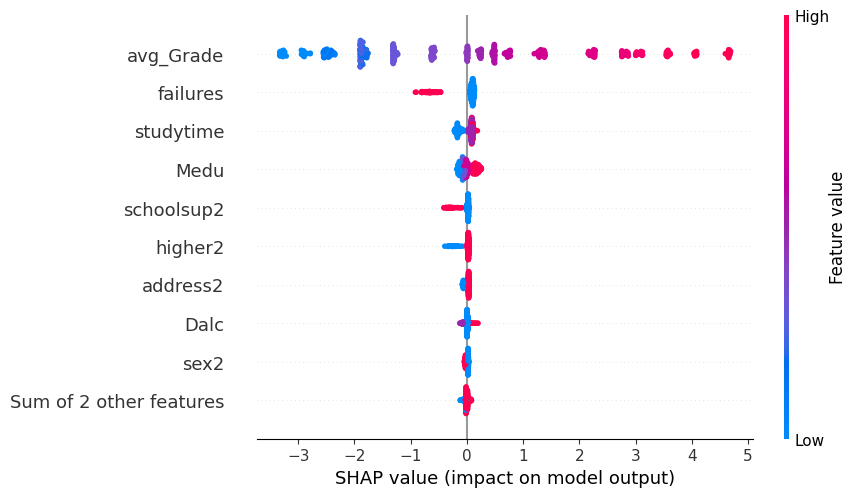

NameError: name 'plt' is not defined

In [38]:
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
import shap
# Initialize XGBoost Regressor
model = xgb.XGBRegressor(
   n_estimators=100,  
   max_depth=3,       
   learning_rate=0.1, 
   subsample=0.9,    
   reg_alpha=5, 
   reg_lambda=5,
   colsample_bytree=0.7, 
   random_state=42    
)

# Use a list to store scores
mse_scores = []
r2_scores = []

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Calculate mean and standard deviation of MSE and R2
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Mean MSE: {:.2f}".format(mse))
print("Mean R^2: {:.2f}".format(r2))


y_pred_train = model.predict(X_train)
train_r2 = r2_score(y_train, y_pred_train)
print("Train R^2 Score:", train_r2)

# Evaluate the best model on the test set
y_pred_test = model.predict(X_test)
test_r2 = r2_score(y_test, y_pred_test)
print("Test R^2 Score:", test_r2)
explainer = shap.Explainer(model,X)
shap_values= explainer(X)
shap.plots.beeswarm(shap_values)


After  adding reguralization the overfitting is much less